In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im)
            preprocessed = preprocess_input(img_to_array(im))
            image_arrays.append(preprocessed)
            all_labels.append(class_id)
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [4]:
X, Y, filenames, all_images = create_dataset('../img/train')

0 office
1 livingroom
2 store
3 suburb
4 kitchen
5 bedroom


In [5]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)
        

In [6]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

# VGG16 : classification utilisant la base de données par defaut

('n04152593', 'screen', 0.22639655)
('n03782006', 'monitor', 0.20265026)
('n02791124', 'barber_chair', 0.165457)
('n02791270', 'barbershop', 0.07090157)
('n03180011', 'desktop_computer', 0.057795048)


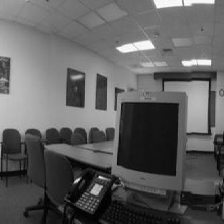

In [7]:
vgg = VGG16()
test_id = 8
predict_image_using_vgg(filenames[test_id], vgg)
all_images[test_id]

**Question** : Commentaire sur le résultat de VGG16 (est-ce que les classes ont du sens pour notre example ou pas)  
**Reponse** : En utilisant la base de donnée par defaut de VGG16, on remarque qu'il a bien identifié l'éxistance d'un ecran dans l'image mais qu'il ne determine pas à quel classe d'image de notre dataset elle appartient.


# VGG16 : classification utilisant notre dataset

In [8]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

x = Dense(20, activation='relu')(x) 

# TODO parametrer le nombre de classes (6 ici)
nb_classes = 6
x = Dense(nb_classes, activation='softmax')(x)  


**Test 1 : epochs=3 et batch_size=5**

In [9]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False
    
custom_model.summary()

# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=5)

Epoch 1/3
886/886 [==============================] - 228s 258ms/step - loss: 4.0547 - acc: 0.6693
Epoch 2/3
886/886 [==============================] - 243s 274ms/step - loss: 1.6125 - acc: 0.8284
Epoch 3/3
886/886 [==============================] - 239s 270ms/step - loss: 0.7372 - acc: 0.8725


**Test : custom_model sur une image en couleur**

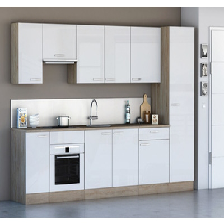

In [15]:
x1, test_filenames1, test_images1 = load_test_set(
   '../img/test_couleur')
test_images1[0]

In [18]:
cuisine_couleur = x1[0].reshape(1, *x1[0].shape)
custom_model.predict(cuisine_couleur)

array([[7.9838698e-11, 4.2966200e-11, 1.7220135e-13, 2.2919616e-20,
        1.0000000e+00, 1.0018804e-19]], dtype=float32)

**Test : custom_model sur une image en noir et blanc**

In [22]:
X_test, test_filenames, test_images = load_test_set(
    '../img/test_images')

In [23]:
X_test.shape

(31, 224, 224, 3)

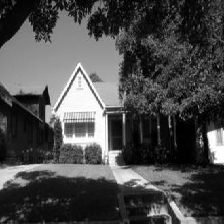

In [24]:
test_id = 5
test_images[test_id]

In [25]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[1.3813926e-24, 1.7608313e-07, 2.4918206e-21, 9.9999940e-01,
        4.7803234e-33, 5.0277509e-07]], dtype=float32)

**Test 2 : epochs=5 et batch_size=10**

In [19]:
custom_model2 = Model(inputs=vgg_cut.input, outputs=x)
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model2.layers[:-2]:
    layer.trainable = False

custom_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
# Compiler le modèle 
custom_model2.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model2.fit(X, Y,
                 epochs=5, batch_size=10)

Epoch 1/5
886/886 [==============================] - 233s 263ms/step - loss: 0.4393 - acc: 0.8984
Epoch 2/5
886/886 [==============================] - 243s 274ms/step - loss: 0.2826 - acc: 0.9233
Epoch 3/5
886/886 [==============================] - 246s 278ms/step - loss: 0.2087 - acc: 0.9334
Epoch 4/5
886/886 [==============================] - 247s 279ms/step - loss: 0.1667 - acc: 0.9345
Epoch 5/5
886/886 [==============================] - 242s 273ms/step - loss: 0.1397 - acc: 0.9436


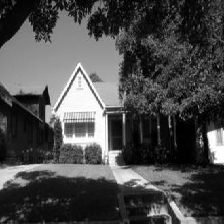

In [26]:
test_id2 = 5
test_images[test_id2]

In [27]:
img_reshaped2 = X_test[test_id2].reshape(1, *X_test[test_id2].shape)
custom_model2.predict(img_reshaped2)

array([[1.3813926e-24, 1.7608313e-07, 2.4918206e-21, 9.9999940e-01,
        4.7803234e-33, 5.0277509e-07]], dtype=float32)